<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/papaya_example_AL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo toy dos mamões:

Esse exemplo foi inspirado em https://www.lighttag.io/blog/active-learning-optimization-is-not-imporvement/, tendo a simulação dos dados:

In [ ]:
# pacotes
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# montando o colab
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# gerando os X's
np.random.seed(1500)
n = 1200
X = np.random.uniform(low=0, high=1, size=(n,2))

# gerando os as classes binárias
y = np.zeros(n)
for i in range(0, n):
  if ((X[i,0])**2 + (X[i,1])**2) <= (0.65**2) and ((X[i,0])**2 + (X[i,1])**2) >= (0.45**2):
    y[i] = 1

sim_data = pd.DataFrame(data = {'X1' : X[:, 0],
                                'X2' : X[:, 1],
                                'Classe' : y})

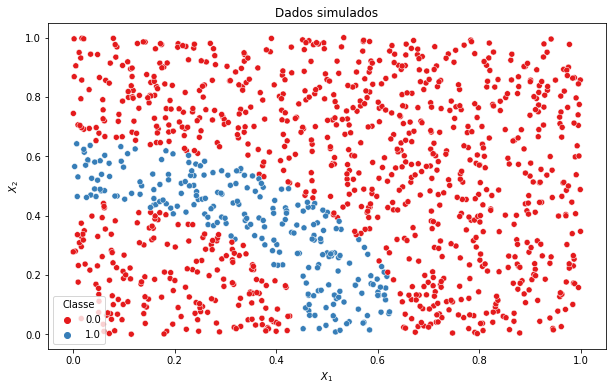

In [ ]:
sns.set_palette("Set1")
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'Classe')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Dados simulados")
plt.savefig(f"{images_dir}/papaya_sim_data.pdf")
plt.show()

Usando um modelo semelhante ao utilizado pelo autor:

In [ ]:
!pip install modAL
from modAL import ActiveLearner
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
# teste para ver desempenho depois
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# setando as amostras iniciais:
np.random.seed(2018)
# 20 de treinamento inicial
n_initial = 20
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# numero de consultas
n_queries = 220
# definindo os indices para plotar
proba_index = [0, 40, 80, 120, 160, 200]

# fazendo uma funcao generica que realiza diversos treinamentos para diferentes modelos
def laco_modelo(proba_index, n_queries, modelo, X_pool, y_pool, X_all, X_test, y_test):
  probas = []
  obs = np.zeros((n_queries, 2))
  # predizendo y
  pred_y_proba = modelo.predict_proba(X_test)[:,1]
  F1_history = [metrics.f1_score(y_test, pred_y_proba > 0.5)]
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)
  for index in range(n_queries):
    if (index) in proba_index:
      probas.append(modelo.predict_proba(X_all)[:, 1])
    # obtendo o indice para perguntar os labels
    query_index, query_instance = modelo.query(X_pool_c)
    X_sel, y_sel = X_pool_c[query_index, :].reshape(1, -1), y_pool_c[query_index].reshape(1, )
    modelo.teach(X = X_sel, y = y_sel)
    obs[index, :] = X_sel
    # para calcular F1
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                  modelo.predict_proba(X_test)[:, 1])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_y_proba = modelo.predict_proba(X_test)[:,1]
    F1_history.append(metrics.f1_score(y_test, pred_y_proba > optimal_threshold))
    X_pool_c, y_pool_c = np.delete(X_pool_c, query_index, axis=0), np.delete(y_pool_c, query_index)
  return(F1_history, probas, obs)

# modelo
learner_svc = ActiveLearner(
    estimator=SVC(kernel = 'rbf', probability=True, random_state = 2018),
    X_training = X_train, 
    y_training = y_train
)

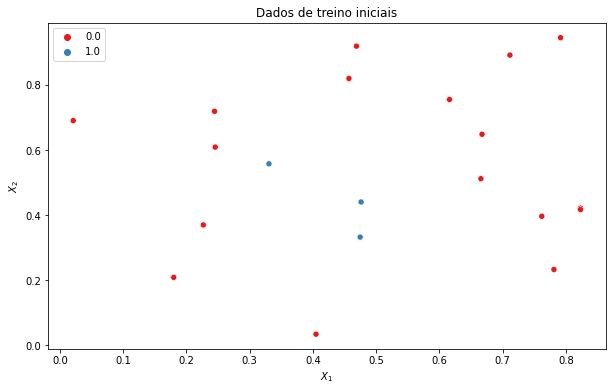

In [ ]:
sns.set_palette("Set1")
plt.figure(figsize = (10,6))
sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue = y_train)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Dados de treino iniciais")
plt.savefig(f"{images_dir}/papaya_train_sim_data.pdf")

Averiguando F1 a cada etapa. Salvando também os predict proba do modelo:

In [ ]:
F1_history, probas, obs = laco_modelo(proba_index, n_queries, learner_svc, X_pool,
                                 y_pool, X, X_test, y_test)

Plotando F1 contra consultas

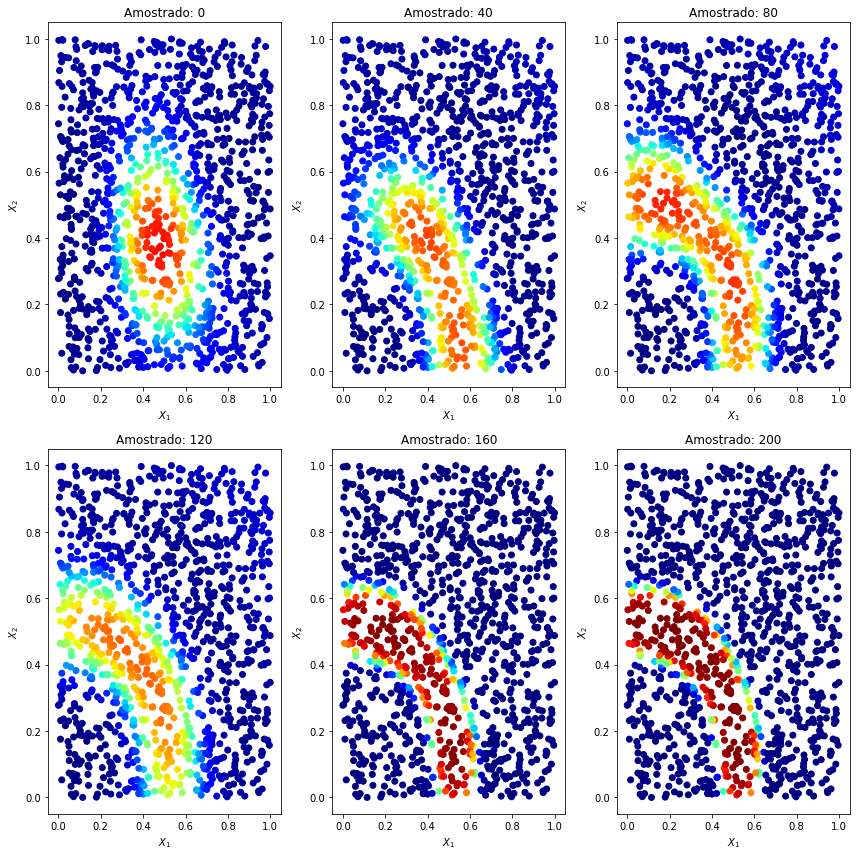

In [ ]:
plt.subplots(2, 3, figsize = (12, 12))
j = 1
for i in range(len(proba_index)):
  plt.subplot(2, 3, j)
  plt.scatter(X[:, 0], X[:, 1], c = probas[i], cmap = "jet")
  plt.title('Amostrado: {}'.format(proba_index[i]))
  plt.xlabel(r"$X_1$")
  plt.ylabel(r"$X_2$")
  plt.clim(0, 1)
  j += 1

plt.tight_layout()
plt.savefig(f"{images_dir}/preditos_SVC_AL_C_1.pdf")
plt.show()

In [ ]:
# amostragem aleatoria
def random_sampling(classifier, X_pool):
  n_samples = len(X_pool)
  query_idx = np.random.choice(range(n_samples))
  return query_idx, X_pool[query_idx]

learner_svc_rand = ActiveLearner(
    estimator=SVC(kernel = 'rbf', probability=True, random_state = 2018),
    X_training = X_train, 
    y_training = y_train,
    query_strategy = random_sampling
)

np.random.seed(1580)
F1_history_rand, probas_rand, obs_rand = laco_modelo(proba_index, n_queries, learner_svc_rand, X_pool,
                                 y_pool, X, X_test, y_test)

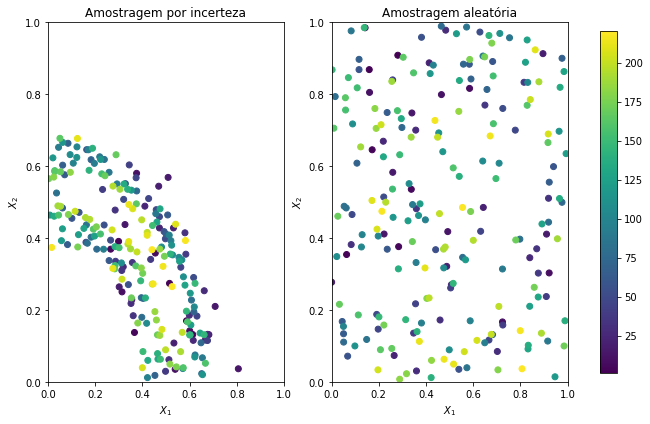

In [ ]:
# observacoes consultadas em cada caso
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 6))

axs = axes.flatten()
axs[0].scatter(obs[:, 0], obs[:, 1], c = np.arange(1, n_queries + 1), cmap = "viridis")
axs[0].set_title('Amostragem por incerteza')
axs[0].set_xlabel(r"$X_1$")
axs[0].set_ylabel(r"$X_2$")
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)

im = axs[1].scatter(obs_rand[:, 0], obs_rand[:, 1], c = np.arange(1, n_queries + 1), cmap = "viridis")
axs[1].set_title('Amostragem aleatória')
axs[1].set_xlabel(r"$X_1$")
axs[1].set_ylabel(r"$X_2$")
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)

plt.tight_layout()
fig.colorbar(im, ax = axes.ravel().tolist(), shrink=0.95)
plt.savefig(f"{images_dir}/obs_amostradas_AL_AA.pdf")

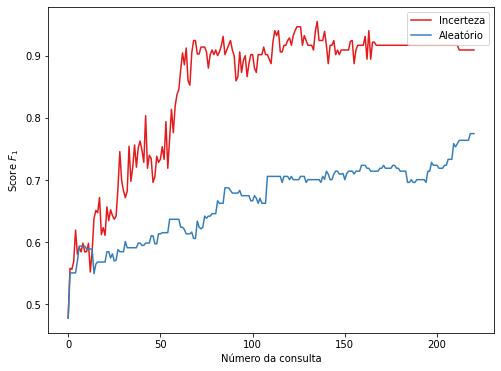

In [ ]:
queries = np.arange(0, 221)
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(F1_history), label = "Incerteza")
plt.plot(queries, np.array(F1_history_rand), label = "Aleatório")
plt.xlabel("Número da consulta")
plt.ylabel(r"Score $F_1$")
plt.legend()
plt.savefig(f"{images_dir}/score_por_consulta_C_1.pdf")
plt.show()

Repetindo os experimentos porém para um modelo ruim:

In [ ]:
# mudando o hiper-parametro C
learner_svc = ActiveLearner(
    estimator= SVC(kernel = 'rbf', probability=True, random_state = 2018, C = 0.01),
    X_training = X_train, 
    y_training = y_train
)

# pegando F1, probas
F1_history, probas, obs = laco_modelo(proba_index, n_queries, learner_svc, X_pool,
                                 y_pool, X, X_test, y_test)

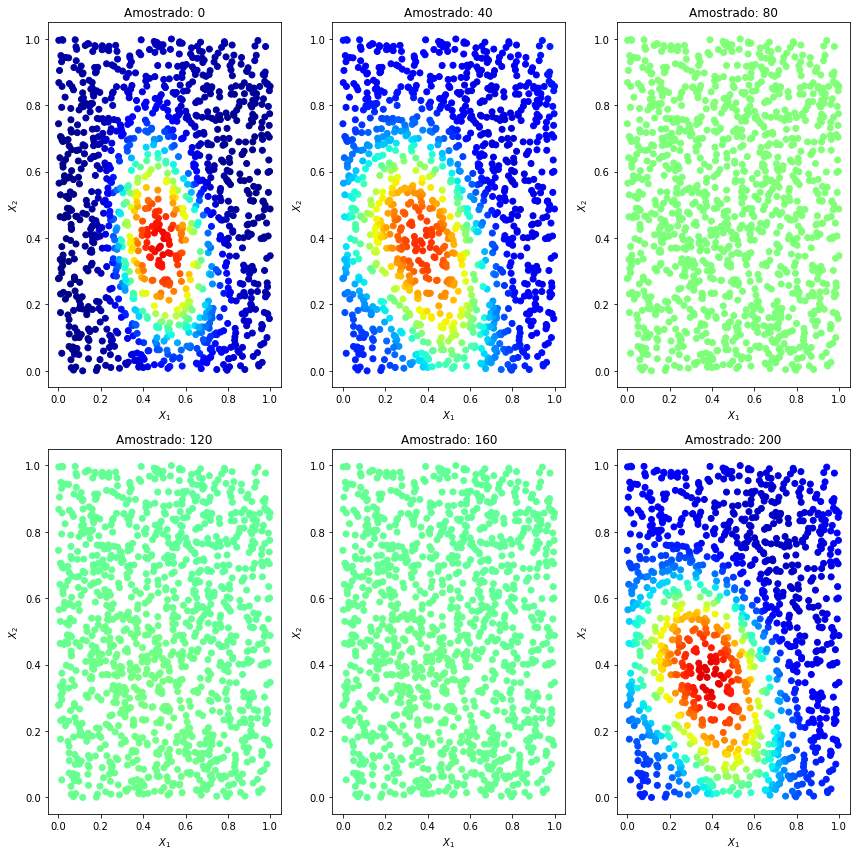

In [ ]:
plt.subplots(2, 3, figsize = (12, 12))
j = 1
for i in range(len(proba_index)):
  plt.subplot(2, 3, j)
  plt.scatter(X[:, 0], X[:, 1], c = probas[i], cmap = "jet")
  plt.title('Amostrado: {}'.format(proba_index[i]))
  plt.xlabel(r"$X_1$")
  plt.ylabel(r"$X_2$")
  plt.clim(0, 1)
  j += 1

plt.tight_layout()
plt.show()

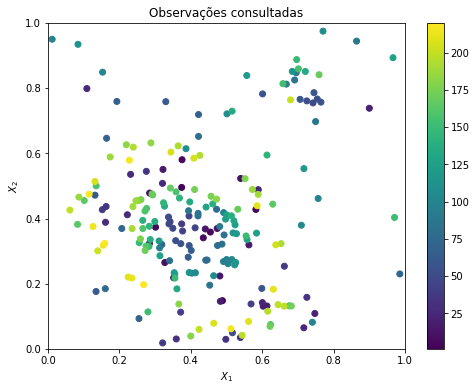

In [ ]:
plt.figure(figsize = (8, 6))
plt.scatter(obs[:, 0], obs[:, 1], c = np.arange(1, n_queries + 1), cmap = "viridis")
plt.title('Observações consultadas')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.clim(1, n_queries)
plt.colorbar()
plt.savefig(f"{images_dir}/obs_amostradas_AL_C_0_01.pdf")

In [ ]:
learner_svc_rand = ActiveLearner(
    estimator=SVC(kernel = 'rbf', probability=True, random_state = 2018, C = 0.01),
    X_training = X_train, 
    y_training = y_train,
    query_strategy = random_sampling
)


np.random.seed(1250)
F1_history_rand, probas_rand, obs = laco_modelo(proba_index, n_queries, learner_svc_rand, X_pool,
                                 y_pool, X, X_test, y_test)

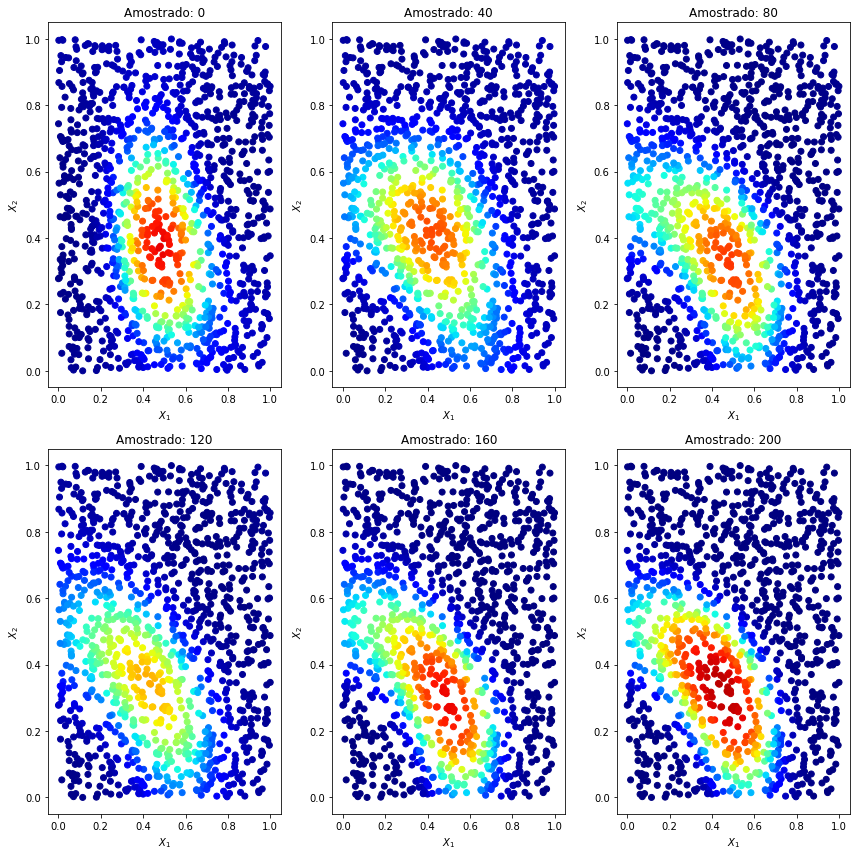

In [ ]:
plt.subplots(2, 3, figsize = (12, 12))
j = 1
for i in range(len(proba_index)):
  plt.subplot(2, 3, j)
  plt.scatter(X[:, 0], X[:, 1], c = probas_rand[i], cmap = "jet")
  plt.title('Amostrado: {}'.format(proba_index[i]))
  plt.xlabel(r"$X_1$")
  plt.ylabel(r"$X_2$")
  plt.clim(0, 1)
  j += 1

plt.tight_layout()
plt.show()

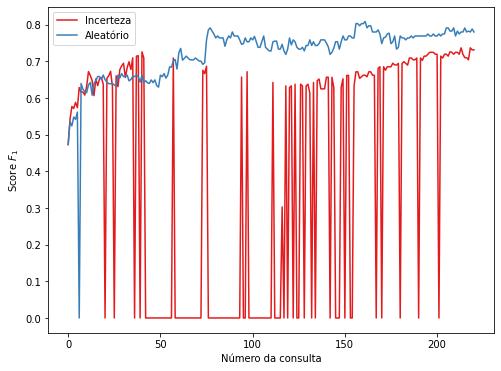

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(F1_history), label = "Incerteza")
plt.plot(queries, np.array(F1_history_rand), label = "Aleatório")
plt.xlabel("Número da consulta")
plt.ylabel(r"Score $F_1$")
plt.legend()
plt.savefig(f"{images_dir}/score_por_consulta_C_0,01.pdf")
plt.show()

Adicionando Random Forest e KNN para comparação e mostrando que nesse exemplo, de fato o active learning funciona bem com modelos não paramétricos e não lineares:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Random forest e KNN
learner_rf = ActiveLearner(
    estimator = RandomForestClassifier(),
    X_training = X_train, 
    y_training = y_train
)

learner_knn = ActiveLearner(
    estimator = KNeighborsClassifier(),
    X_training = X_train, 
    y_training = y_train
)

learner_rf_rand = ActiveLearner(
    estimator = RandomForestClassifier(),
    X_training = X_train, 
    y_training = y_train,
    query_strategy = random_sampling
)

learner_knn_rand = ActiveLearner(
    estimator = KNeighborsClassifier(),
    X_training = X_train, 
    y_training = y_train,
    query_strategy = random_sampling
)

Plotando $F_1$ para AL e AA no KNN e RF:

In [ ]:
# F1 usando amostragem por incerteza para RF
F1_history_rf, probas_rf, _ = laco_modelo(proba_index, n_queries, learner_rf, X_pool,
                                 y_pool, X, X_test, y_test)

# F1 usando amostragem aleatória para RF
F1_history_rf_rand, probas_rf_rand, _ = laco_modelo(proba_index, n_queries, learner_rf_rand, X_pool,
                                 y_pool, X, X_test, y_test)

In [ ]:
# F1 usando amostragem por incerteza para KNN
F1_history_knn, probas_knn, _ = laco_modelo(proba_index, n_queries, learner_knn, X_pool,
                                 y_pool, X, X_test, y_test)

# F1 usando amostragem aleatória para KNN
F1_history_knn_rand, probas_knn_rand, _ = laco_modelo(proba_index, n_queries, learner_knn_rand, X_pool,
                                 y_pool, X, X_test, y_test)

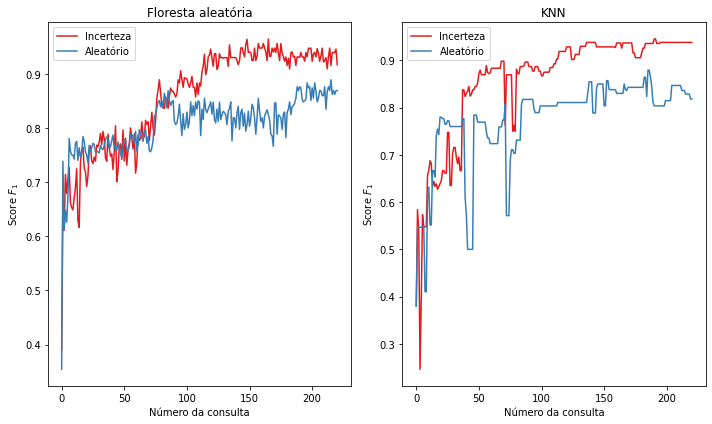

In [ ]:
plt.subplots(1, 2, figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.plot(queries, np.array(F1_history_rf), label = "Incerteza")
plt.plot(queries, np.array(F1_history_rf_rand), label = "Aleatório")
plt.xlabel("Número da consulta")
plt.ylabel(r"Score $F_1$")
plt.title("Floresta aleatória")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(queries, np.array(F1_history_knn), label = "Incerteza")
plt.plot(queries, np.array(F1_history_knn_rand), label = "Aleatório")
plt.xlabel("Número da consulta")
plt.ylabel(r"Score $F_1$")
plt.title("KNN")

plt.tight_layout()
plt.legend()
plt.savefig(f"{images_dir}/score_por_consulta_RF_KNN.pdf")
plt.show()